# Super Simple Keras model on TriFeature for multiplicity determination

In [1]:
import numpy as np
import pandas as pd
import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.1


In [2]:
num_dp = 30
max_neutrons = 5
label = "nPH"

traindata = pd.read_pickle(f"data/training_600AMeV_{num_dp}dp.pkl").sample(frac=1)
x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

print(x_train)
print(y_train)

[[  50   24  874]
 [  18    7  192]
 [  55   36 1088]
 ...
 [  86   49 1231]
 [  34   11  664]
 [  85   23 1559]]
[[0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=24, activation="relu", input_shape=(3,)))
model.add(keras.layers.Dense(units=9, activation="relu"))
model.add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

optimizer = keras.optimizers.Adagrad()#lr=0.01, decay=0.0)
loss = keras.losses.categorical_crossentropy
model.compile(loss=loss, optimizer=optimizer, metrics=["acc"])

history = model.fit(x=x_train, y=y_train, batch_size=1000, epochs=100, verbose=1)

Epoch 1/100
4999569/4999569 [==============================] - 10s 2us/step - loss: 1.1948 - acc: 0.4897
Epoch 2/100
4999569/4999569 [==============================] - 9s 2us/step - loss: 0.7583 - acc: 0.6864
Epoch 3/100
4999569/4999569 [==============================] - 9s 2us/step - loss: 0.6940 - acc: 0.7124
Epoch 4/100
4999569/4999569 [==============================] - 9s 2us/step - loss: 0.6704 - acc: 0.7184
Epoch 5/100
4999569/4999569 [==============================] - 9s 2us/step - loss: 0.6599 - acc: 0.7200
Epoch 6/100
4999569/4999569 [==============================] - 9s 2us/step - loss: 0.6535 - acc: 0.7213
Epoch 7/100
4999569/4999569 [==============================] - 10s 2us/step - loss: 0.6499 - acc: 0.7220
Epoch 8/100
4999569/4999569 [==============================] - 10s 2us/step - loss: 0.6476 - acc: 0.7226
Epoch 9/100
4999569/4999569 [==============================] - 9s 2us/step - loss: 0.6463 - acc: 0.7226
Epoch 10/100
4999569/4999569 [==============================]

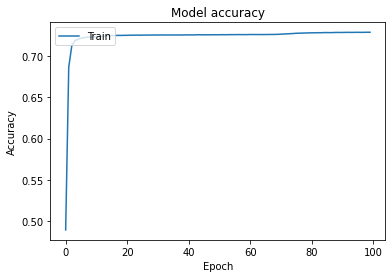

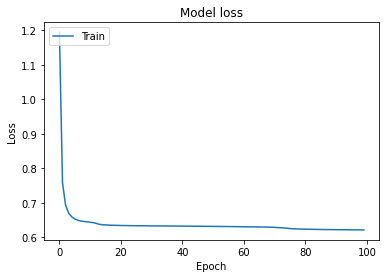

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history["acc"])
#plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
#plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [23]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

testdata = pd.read_pickle(f"data/test_600AMeV_{num_dp}dp.pkl").sample(frac=1)
x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

y_pred = model.predict(x_test)
print(list(zip(y_true, y_pred))[0:10])


y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
print(cmrel)

[(3, array([0.   , 0.   , 0.204, 0.67 , 0.12 , 0.006], dtype=float32)), (3, array([0.   , 0.   , 0.003, 0.513, 0.43 , 0.054], dtype=float32)), (3, array([0.   , 0.   , 0.   , 0.33 , 0.558, 0.112], dtype=float32)), (3, array([0.   , 0.   , 0.539, 0.42 , 0.04 , 0.001], dtype=float32)), (5, array([0.   , 0.   , 0.037, 0.654, 0.283, 0.026], dtype=float32)), (5, array([0.   , 0.   , 0.   , 0.001, 0.138, 0.861], dtype=float32)), (4, array([0.   , 0.   , 0.007, 0.541, 0.401, 0.051], dtype=float32)), (3, array([0.   , 0.   , 0.624, 0.354, 0.021, 0.   ], dtype=float32)), (5, array([0.   , 0.   , 0.   , 0.012, 0.376, 0.613], dtype=float32)), (1, array([0.   , 0.992, 0.008, 0.   , 0.   , 0.   ], dtype=float32))]
0.7731722575752052
[[ 2363     0     0     0     0     0]
 [    0 98068  4183     0     0     0]
 [    0 13494 80606  7922     3     0]
 [    0   812 22669 59809 18651    62]
 [    0    29  2483 20203 58955 19592]
 [    0     0   126  2540 22431 64964]]
[[1.    0.    0.    0.    0.    0. 

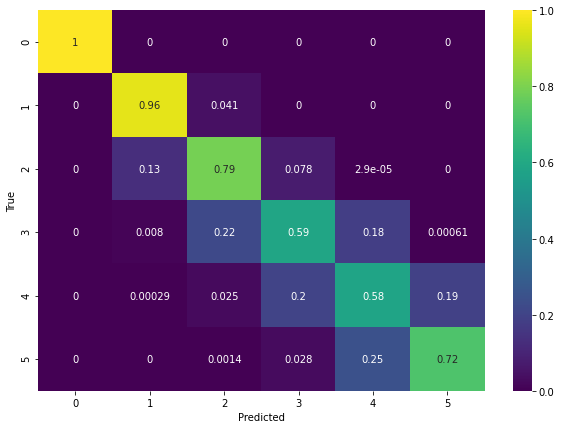

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True");